In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib

import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
def StringToBytes(data):
    sum = 0
    arrbytes = bytes(data, 'utf-8')
    for i in arrbytes:
        sum = sum + i
    return(sum)

In [3]:
data_normal_1 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_normal_1.csv')
data_normal_2 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_normal_2.csv')
data_normal_3 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_normal_3.csv')
data_normal_4 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_normal_4.csv')

data_normal_5 = pd.read_csv('dataset/timeseries/old/dataset_tcp_timeseries_normal_3.csv')

data_attack_1 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_attack_1.csv')
data_attack_2 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_attack_2.csv')
data_attack_3 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_attack_3.csv')

data_attack_4 = pd.read_csv('dataset/timeseries/old/dataset_tcp_timeseries_attack_1.csv')

In [4]:
data_normal_1.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_normal_2.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_normal_3.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_normal_4.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']

data_normal_5.columns = ['timestamp', 'port_src', 'port_dest',
       'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']

data_attack_1.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_attack_2.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_attack_3.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']

data_attack_4.columns = ['timestamp', 'port_src', 'port_dest',
       'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']

In [5]:
data_normal_5 = data_normal_5.drop(['timestamp', 'port_dest'],axis=1)

data_attack_4 = data_attack_4.drop(['timestamp', 'port_dest'],axis=1)

In [6]:
features = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len']

In [7]:
X_normal_1 = data_normal_1[features].values
X_normal_2 = data_normal_2[features].values
X_normal_3 = data_normal_3[features].values
X_normal_4 = data_normal_4[features].values
X_normal_5 = data_normal_5[features].values

X_attack_1 = data_attack_1[features].values
X_attack_2 = data_attack_2[features].values
X_attack_3 = data_attack_3[features].values
X_attack_4 = data_attack_4[features].values

Y_normal_1 = data_normal_1['label']
Y_normal_2 = data_normal_2['label']
Y_normal_3 = data_normal_3['label']
Y_normal_4 = data_normal_4['label']
Y_normal_5 = data_normal_5['label']

Y_attack_1 = data_attack_1['label']
Y_attack_2 = data_attack_2['label']
Y_attack_3 = data_attack_3['label']
Y_attack_4 = data_attack_4['label']

X=np.concatenate((X_normal_1,X_normal_2,X_normal_3,X_normal_4,X_normal_5,X_attack_1,X_attack_2,X_attack_3,X_attack_4))
Y=np.concatenate((Y_normal_1,Y_normal_2,Y_normal_3,Y_normal_4,Y_normal_5,Y_attack_1,Y_attack_2,Y_attack_3,Y_attack_4))

In [8]:
for i in range(len(X)):
    X[i][5] = StringToBytes(str(X[i][5]))

In [9]:
data_counter = Counter(Y)
print(data_counter)

Counter({0: 96512, 1: 90273})


In [10]:
over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, Y = pipeline.fit_resample(X, Y)

In [11]:
data_counter = Counter(Y)
print(data_counter)

Counter({0: 96512, 1: 96512})


In [12]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [13]:
print(np.shape(X))
print(np.shape(Y))

(193024, 10)
(193024,)


In [14]:
features = len(X[0])
samples = X.shape[0]
train_len = 50
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

In [15]:
for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [16]:
print(I.shape)

(192974, 50, 10)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[50:], test_size = 0.2, stratify=Y[50:], random_state = 0)

In [18]:
def create_baseline():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [19]:
model = create_baseline()

In [20]:
history = model.fit(X_train, Y_train, epochs = 20,validation_split=0.2, verbose = 1)

Epoch 1/20
3860/3860 [==============================] - 44s 11ms/step - loss: 0.0505 - accuracy: 0.9997 - val_loss: 0.0255 - val_accuracy: 0.9996
Epoch 2/20
3860/3860 [==============================] - 42s 11ms/step - loss: 0.0264 - accuracy: 0.9994 - val_loss: 0.0375 - val_accuracy: 0.9998
Epoch 3/20
3860/3860 [==============================] - 42s 11ms/step - loss: 0.0282 - accuracy: 0.9999 - val_loss: 0.0247 - val_accuracy: 0.9998
Epoch 4/20
3860/3860 [==============================] - 42s 11ms/step - loss: 0.0220 - accuracy: 0.9999 - val_loss: 0.0207 - val_accuracy: 0.9997
Epoch 5/20
3860/3860 [==============================] - 42s 11ms/step - loss: 0.0395 - accuracy: 0.9975 - val_loss: 0.0347 - val_accuracy: 0.9996
Epoch 6/20
3860/3860 [==============================] - 42s 11ms/step - loss: 0.0301 - accuracy: 0.9983 - val_loss: 0.0764 - val_accuracy: 0.9905
Epoch 7/20
3860/3860 [==============================] - 41s 11ms/step - loss: 0.0353 - accuracy: 0.9984 - val_loss: 0.0233 -

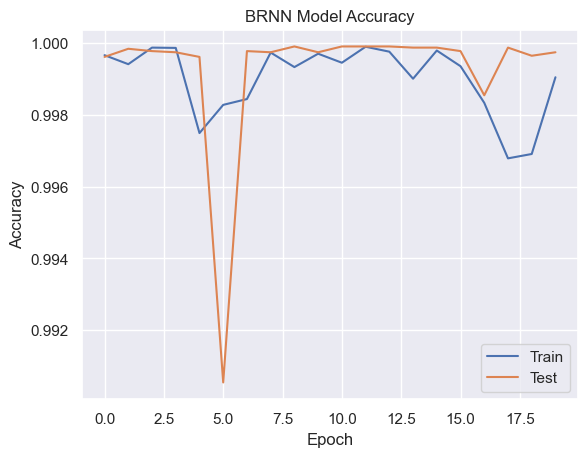

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN 500 Model Accuracy.png')
plt.show()

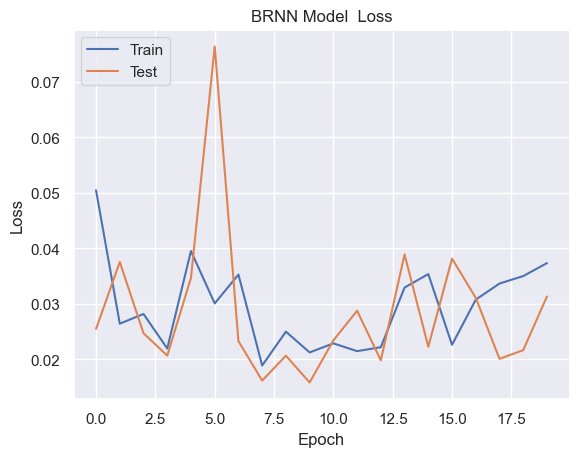

In [22]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN 50 Model Loss.png')
plt.show()

In [23]:
predict = model.predict(X_test, verbose=1)

1207/1207 [==============================] - 5s 4ms/step


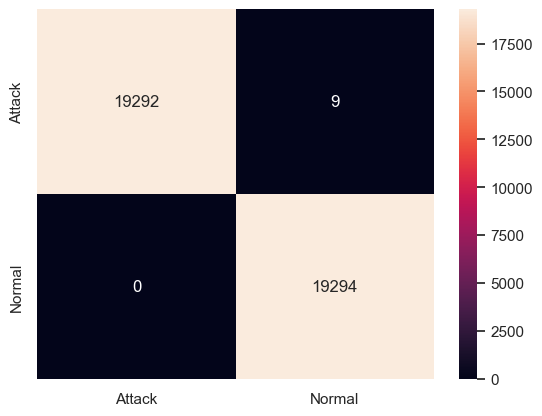

In [24]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [25]:
figure = ax.get_figure()
figure.savefig('confusion_matrix_BRNN_50.png', dpi=400)

In [26]:
model.save('brnn_model_50_step.h5')
joblib.dump(scalar, 'scaler_50.save')

['scaler_50.save']

In [27]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.98%


In [28]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19292
           1       1.00      1.00      1.00     19303

    accuracy                           1.00     38595
   macro avg       1.00      1.00      1.00     38595
weighted avg       1.00      1.00      1.00     38595



In [29]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=1.000


In [30]:
time_start = time.perf_counter()
predict = model.predict(I[:50], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

2/2 [==============================] - 0s 7ms/step
Time elapse for prediction : 0.043987600000036764
[[0.00445637]
 [0.00445637]
 [0.00445638]
 [0.00445637]
 [0.00445638]
 [0.00445637]
 [0.00445639]
 [0.00445639]
 [0.00445639]
 [0.00445639]
 [0.00445638]
 [0.00445638]
 [0.00445639]
 [0.00445638]
 [0.00445638]
 [0.00445638]
 [0.00445638]
 [0.00445638]
 [0.00445638]
 [0.00445638]
 [0.0044564 ]
 [0.00445639]
 [0.00445639]
 [0.00445638]
 [0.00445639]
 [0.00445639]
 [0.00445639]
 [0.00445639]
 [0.00445639]
 [0.00445639]
 [0.0044564 ]
 [0.00445639]
 [0.00445638]
 [0.00445638]
 [0.00445638]
 [0.00445638]
 [0.00445638]
 [0.00445637]
 [0.00445636]
 [0.00445636]
 [0.00445638]
 [0.00445638]
 [0.00445636]
 [0.00445637]
 [0.00445638]
 [0.00445636]
 [0.00445636]
 [0.00445636]
 [0.00445637]
 [0.00445637]]


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              38400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 55,041
Trainable params: 55,041
Non-trainable params: 0
_________________________________________________________________
